In [ ]:
!pip install install transformers datasets evaluate

In [ ]:
from transformers import AutoImageProcessor, DefaultDataCollator, create_optimizer, TFAutoModelForImageClassification
from datasets import load_dataset
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from transformers.keras_callbacks import KerasMetricCallback
import numpy as np
import tensorflow as tf
import PIL as Image



In [ ]:


food = load_dataset("food101", split = "train[:5000]")

In [ ]:
food = food.train_test_split(test_size = 0.2)

In [ ]:
food["train"][0]

{'image': <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=512x512>,
 'label': 81}

In [ ]:
food["train"].features

{'image': Image(decode=True, id=None),
 'label': ClassLabel(names=['apple_pie', 'baby_back_ribs', 'baklava', 'beef_carpaccio', 'beef_tartare', 'beet_salad', 'beignets', 'bibimbap', 'bread_pudding', 'breakfast_burrito', 'bruschetta', 'caesar_salad', 'cannoli', 'caprese_salad', 'carrot_cake', 'ceviche', 'cheesecake', 'cheese_plate', 'chicken_curry', 'chicken_quesadilla', 'chicken_wings', 'chocolate_cake', 'chocolate_mousse', 'churros', 'clam_chowder', 'club_sandwich', 'crab_cakes', 'creme_brulee', 'croque_madame', 'cup_cakes', 'deviled_eggs', 'donuts', 'dumplings', 'edamame', 'eggs_benedict', 'escargots', 'falafel', 'filet_mignon', 'fish_and_chips', 'foie_gras', 'french_fries', 'french_onion_soup', 'french_toast', 'fried_calamari', 'fried_rice', 'frozen_yogurt', 'garlic_bread', 'gnocchi', 'greek_salad', 'grilled_cheese_sandwich', 'grilled_salmon', 'guacamole', 'gyoza', 'hamburger', 'hot_and_sour_soup', 'hot_dog', 'huevos_rancheros', 'hummus', 'ice_cream', 'lasagna', 'lobster_bisque', 'lo

In [ ]:
labels = food["train"].features["label"].names
label2id, id2label = dict(), dict()

for i, label in enumerate(labels):
  label2id[label] = str(i)
  id2label[str(i)] = label

In [ ]:
id2label[str(79)]

'prime_rib'

**Preprocess**

In [ ]:

checkpoint = "google/vit-base-patch16-224-in21k"
image_processor = AutoImageProcessor.from_pretrained(checkpoint)

In [ ]:
food["train"][0]

{'image': <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=512x512>,
 'label': 81,
 'pixel_values': <tf.Tensor: shape=(3, 224, 224), dtype=float32, numpy=
 array([[[-0.28663424, -0.3404888 , -0.3983311 , ..., -0.77254903,
          -0.7723047 , -0.76504177],
         [-0.2785558 , -0.34076205, -0.39948076, ..., -0.77280426,
          -0.77202433, -0.76523584],
         [-0.27826592, -0.34611815, -0.41431606, ..., -0.7805934 ,
          -0.7707411 , -0.7639114 ],
         ...,
         [ 0.24679221,  0.28441083,  0.33167663, ..., -0.8852997 ,
          -0.8888384 , -0.8782162 ],
         [ 0.16343714,  0.21424061,  0.282319  , ..., -0.8851856 ,
          -0.88954765, -0.88502234],
         [ 0.07254311,  0.13852589,  0.22974595, ..., -0.8781475 ,
          -0.887663  , -0.8903059 ]],
 
        [[-0.5082103 , -0.535461  , -0.5544898 , ..., -0.78072315,
          -0.7864224 , -0.78049606],
         [-0.5107571 , -0.5327563 , -0.54856443, ..., -0.78355575,
          -0.7871157 , -0.7

In [ ]:
size = (image_processor.size["height"], image_processor.size["width"])

train_data_augmentation = keras.Sequential(
    [
        layers.RandomCrop(size[0], size[1]),
        layers.Rescaling(scale=1.0/127.5, offset=-1),
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(factor=0.02),
        layers.RandomZoom(height_factor=0.2, width_factor=0.2),
    ],
    name = "train_data_augmentation",
)

val_data_augmentation = keras.Sequential(
    [
        layers.CenterCrop(size[0], size[1]),
        layers.Rescaling(scale=1.0/127.5, offset=-1),
    ],
    name ="val_data_augmentation",
)

In [ ]:
def convert_to_tf_tensor(image:Image):
  np_image = np.array(image)
  tf_image = tf.convert_to_tensor(np_image)

  return tf.expand_dims(tf_image,0)

def preprocess_train(example_batch):
  images = [
      train_data_augmentation(convert_to_tf_tensor(image.convert("RGB"))) for image in example_batch["image"]
  ]
  example_batch["pixel_values"] = [tf.transpose(tf.squeeze(image)) for image in images]

  return example_batch

def preprocess_val(example_batch):
    """Apply val_transforms across a batch."""
    images = [
        val_data_augmentation(convert_to_tf_tensor(image.convert("RGB"))) for image in example_batch["image"]
    ]
    example_batch["pixel_values"] = [tf.transpose(tf.squeeze(image)) for image in images]
    return example_batch



In [ ]:
food["train"][1]

{'image': <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=385x512>,
 'label': 81}

In [ ]:
food["train"].set_transform(preprocess_train)
food["test"].set_transform(preprocess_val)

In [ ]:
food["test"][1]

{'image': <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=512x512>,
 'label': 20,
 'pixel_values': <tf.Tensor: shape=(3, 224, 224), dtype=float32, numpy=
 array([[[ 0.39607847,  0.38823533,  0.36470592, ...,  0.30980396,
           0.41960788,  0.38823533],
         [ 0.36470592,  0.38823533,  0.39607847, ...,  0.27058828,
           0.36470592,  0.33333337],
         [ 0.38823533,  0.37254906,  0.3803922 , ...,  0.1686275 ,
           0.22352946,  0.19215691],
         ...,
         [ 0.96078444,  0.9686276 ,  0.9686276 , ...,  0.33333337,
           0.36470592,  0.38823533],
         [ 0.9764707 ,  0.9764707 ,  0.98431385, ...,  0.30196083,
           0.30980396,  0.32549024],
         [ 0.9764707 ,  0.9764707 ,  0.98431385, ...,  0.2941177 ,
           0.2941177 ,  0.2941177 ]],
 
        [[ 0.12941182,  0.12156868,  0.09803927, ..., -0.31764704,
          -0.22352934, -0.25490195],
         [ 0.10588241,  0.11372554,  0.12156868, ..., -0.36470586,
          -0.2862745 , -0.3

In [ ]:
data_collator = DefaultDataCollator(return_tensors="tf")

In [ ]:
data_collator

DefaultDataCollator(return_tensors='tf')

**Evaluation**

In [ ]:
import evaluate

accuracy = evaluate.load("accuracy")

In [ ]:
def compute_metrics(eval_pred):
  predictions, labels = eval_pred
  predictions = np.argmax(predictions, axis=1)

  return accuracy.compute(predictions=predictions, references=labels)

**Train**

In [ ]:
batch_size = 16
num_epochs = 5
num_train_steps = len(food["train"])*num_epochs
learning_rate = 3e-5
weight_decay_rate = 0.01

optimizer, lr_schedule = create_optimizer(
    init_lr = learning_rate,
    num_train_steps = num_train_steps,
    weight_decay_rate = weight_decay_rate,
    num_warmup_steps = 0,
)

In [ ]:
model = TFAutoModelForImageClassification.from_pretrained(
    checkpoint,
    id2label = id2label,
    label2id = label2id,
)

tf_train_dataset = food["train"].to_tf_dataset(
    columns = "pixel_values", label_cols ="label", shuffle=True, batch_size=batch_size, collate_fn=data_collator
)

tf_eval_dataset = food["test"].to_tf_dataset(
    columns = "pixel_values", label_cols="label", shuffle=True, batch_size = batch_size, collate_fn = data_collator
)

Some layers from the model checkpoint at google/vit-base-patch16-224-in21k were not used when initializing TFViTForImageClassification: ['vit/pooler/dense/bias:0', 'vit/pooler/dense/kernel:0']
- This IS expected if you are initializing TFViTForImageClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFViTForImageClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some layers of TFViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
model.compile(optimizer = optimizer, loss=loss)

In [ ]:
metric_callback = KerasMetricCallback(metric_fn = compute_metrics, eval_dataset=tf_eval_dataset)
callback = metric_callback

In [ ]:
model.fit(tf_train_dataset, validation_data=tf_eval_dataset, epochs = num_epochs, callbacks = callback)

Epoch 1/5
250/250 [==============================] - 384s 1s/step - loss: 2.8102 - val_loss: 1.5871 - accuracy: 0.8430
Epoch 2/5
250/250 [==============================] - 352s 1s/step - loss: 1.1902 - val_loss: 0.8112 - accuracy: 0.8980
Epoch 3/5
250/250 [==============================] - 368s 1s/step - loss: 0.6866 - val_loss: 0.4643 - accuracy: 0.9280
Epoch 4/5
250/250 [==============================] - 414s 2s/step - loss: 0.4823 - val_loss: 0.3765 - accuracy: 0.9240
Epoch 5/5
250/250 [==============================] - 351s 1s/step - loss: 0.3800 - val_loss: 0.2993 - accuracy: 0.9380


In [ ]:
ds = load_dataset("food101", split="validation[:10]")
image = ds["image"][4]

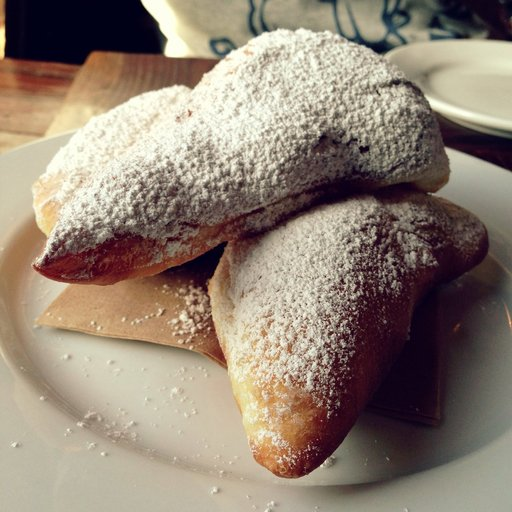

In [ ]:
image

In [ ]:
from transformers import pipeline
classifier = pipeline("image-classification", model="my_awesome_food_model/checkpoint-45", )
classifier(image)

Could not find image processor class in the image processor config or the model config. Loading based on pattern matching with the model's feature extractor configuration.


[{'score': 0.35989895462989807, 'label': 'beignets'},
 {'score': 0.016103219240903854, 'label': 'chicken_wings'},
 {'score': 0.015893878415226936, 'label': 'prime_rib'},
 {'score': 0.014910886064171791, 'label': 'hamburger'},
 {'score': 0.014522010460495949, 'label': 'bruschetta'}]